In [242]:
#Set seed to 42 fo everything
import numpy as np
import random
import torch

def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    
seed_everything(42)

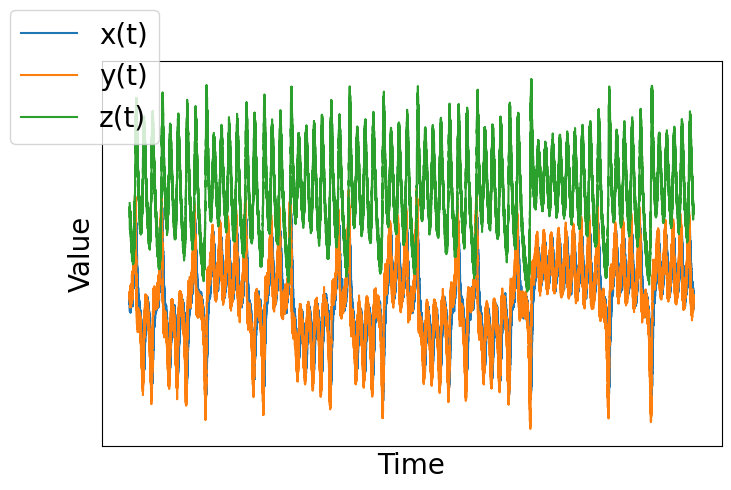

In [243]:
#Simulate and plot a nonlinear time series

# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import math

import numpy as np
import matplotlib.pyplot as plt

# Define the Lorenz system parameters
sigma = 10.0
rho = 28.0
beta = 8.0 / 3.0

# Define the Lorenz system equations
def lorenz_system(state, t):
    x, y, z = state
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
    return [dx, dy, dz]

# Set the initial conditions and time span
initial_state = [0.0, 1.0, 20.0]
t = np.linspace(0, 50, 50000)  # Time span and number of time steps

# Use an ODE solver to integrate the Lorenz system
from scipy.integrate import odeint
solution = odeint(lorenz_system, initial_state, t)

# Extract the time series for x, y, and z
x = solution[:, 0] + np.random.normal(0, 1, len(solution[:, 0]))
y = solution[:, 1] + np.random.normal(0, 1, len(solution[:, 1]))
z = solution[:, 2] + np.random.normal(0, 1, len(solution[:, 2]))

# add a quadratic multiplicative trend to the time series
#trend = np.square(0.5*t)-12*t
#x = x + trend
#y = y + trend
#z = z + trend

# Plot the time series with minimal style
plt.figure(figsize=(8, 5))
plt.plot(t, x, label='x(t)')
plt.plot(t, y, label='y(t)')
plt.plot(t, z, label='z(t)')
plt.xlabel('Time', fontsize=20)
plt.ylabel('Value', fontsize=20)

#Remove ticks
plt.xticks([])
plt.yticks([])

plt.legend(fontsize=20,  loc='upper left', bbox_to_anchor=(-0.17, 1.17))
#plt.savefig('figs/Lorenz.pdf')
plt.show()







In [244]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

# Parameters
input_sequence_length = 500  # Length of the input sequence
output_sequence_length = 500  # Length of the output sequence (target)

# Create input sequences and target sequences
input_sequences = []
target_sequences = []

total_time_steps = len(y)
end_train_index = int(0.7 * total_time_steps)
end_val_index = int(0.8 * total_time_steps)

for i in range(total_time_steps - input_sequence_length - output_sequence_length):
    input_seq = np.column_stack((x[i:i+input_sequence_length], y[i:i+input_sequence_length], z[i:i+input_sequence_length]))
    target_seq = y[i+input_sequence_length:i+input_sequence_length+output_sequence_length]
    input_sequences.append(input_seq)
    target_sequences.append(target_seq)

# Convert the input and target sequences to numpy arrays
input_sequences = np.array(input_sequences)
target_sequences = np.array(target_sequences)

# Split the dataset into training and test sets
X_train = input_sequences[:end_train_index]
y_train = target_sequences[:end_train_index]
X_val = input_sequences[end_train_index:end_val_index]
y_val = target_sequences[end_train_index:end_val_index]
X_test = input_sequences[end_val_index:]
y_test = target_sequences[end_val_index:]

# Define a custom PyTorch dataset
class CustomDataset(Dataset):
    def __init__(self, input_sequences, target_sequences):
        self.input_sequences = input_sequences
        self.target_sequences = target_sequences

    def __len__(self):
        return len(self.input_sequences)

    def __getitem__(self, idx):
        x = torch.tensor(self.input_sequences[idx], dtype=torch.float32)
        y = torch.tensor(self.target_sequences[idx], dtype=torch.float32)
        return x, y

# Create DataLoader instances for training and test sets
batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = CustomDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_dataset = CustomDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [245]:
# Define a Feedforward Neural Network that use Relu activation function if linear = False and a linear activation function if linear = True
import torch.nn as nn
import torch.nn.functional as F

class FeedforwardNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, linear):
        super(FeedforwardNeuralNetwork, self).__init__()
        self.relu = nn.ReLU()
        self.linear = linear
        print('Linear Model:', self.linear)
        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)


    def forward(self, x):        
        if self.linear == False:
            out = self.relu(self.fc1(x))
            out = self.relu(self.fc2(out))
            out = self.fc3(out)
        else:
            out = self.fc1(x)
            out = self.fc2(out)
            out = self.fc3(out)
        return out


In [246]:
# Define a Feedforward Neural Network
input_size = input_sequence_length * 3  # Each sequence has x, y, z values
hidden_size = 64  # Example hidden layer size
output_size = output_sequence_length

nonlinear_model = FeedforwardNeuralNetwork(input_size, hidden_size, output_size, linear=False)

# Define Loss Function and Optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = torch.optim.Adam(nonlinear_model.parameters())  # Using Adam optimizer

# Training Loop with Early Stopping
epochs = 100
patience = 10  # Number of epochs to wait for improvement in validation loss

best_val_loss = float('inf')
patience_counter = 0

for epoch in range(epochs):
    # Training phase
    nonlinear_model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = nonlinear_model(inputs.view(inputs.size(0), -1))
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    # Validation phase
    nonlinear_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = nonlinear_model(inputs.view(inputs.size(0), -1))
            val_loss += criterion(outputs, targets).item()

    val_loss /= len(val_loader)

    print(f"Epoch {epoch+1}, Validation Loss: {val_loss}")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered")
        break


Linear Model: False
Epoch 1, Validation Loss: 6.387685011146934
Epoch 2, Validation Loss: 4.348960723087287
Epoch 3, Validation Loss: 4.356816629695285
Epoch 4, Validation Loss: 3.512795101305482
Epoch 5, Validation Loss: 2.963638368685534
Epoch 6, Validation Loss: 2.8890551837386598
Epoch 7, Validation Loss: 2.2743161233367433
Epoch 8, Validation Loss: 2.3345503123702516
Epoch 9, Validation Loss: 2.5437039668392982
Epoch 10, Validation Loss: 2.0892834944330203
Epoch 11, Validation Loss: 2.4897376147045454
Epoch 12, Validation Loss: 2.719050884246826
Epoch 13, Validation Loss: 2.4154207190130927
Epoch 14, Validation Loss: 2.670757153231627
Epoch 15, Validation Loss: 2.5333788584751686
Epoch 16, Validation Loss: 2.2111760294361478
Epoch 17, Validation Loss: 2.089688684530319
Epoch 18, Validation Loss: 2.1381344992643707
Epoch 19, Validation Loss: 2.4495348763314024
Epoch 20, Validation Loss: 2.497800199848831
Early stopping triggered


In [247]:
# Define a Feedforward Neural Network
input_size = input_sequence_length * 3  # Each sequence has x, y, z values
hidden_size = 64  # Example hidden layer size
output_size = output_sequence_length

linear_model = FeedforwardNeuralNetwork(input_size, hidden_size, output_size, linear=True)

# Define Loss Function and Optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = torch.optim.Adam(linear_model.parameters())  # Using Adam optimizer

# Training Loop with Early Stopping
epochs = 100
patience = 10  # Number of epochs to wait for improvement in validation loss

best_val_loss = float('inf')
patience_counter = 0

for epoch in range(epochs):
    # Training phase
    linear_model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = linear_model(inputs.view(inputs.size(0), -1))
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    # Validation phase
    linear_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = linear_model(inputs.view(inputs.size(0), -1))
            val_loss += criterion(outputs, targets).item()

    val_loss /= len(val_loader)

    print(f"Epoch {epoch+1}, Validation Loss: {val_loss}")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered")
        break

Linear Model: True
Epoch 1, Validation Loss: 49.68491456159361
Epoch 2, Validation Loss: 51.942266476382116
Epoch 3, Validation Loss: 52.46602436843192
Epoch 4, Validation Loss: 45.25853916338295
Epoch 5, Validation Loss: 60.803616380995244
Epoch 6, Validation Loss: 54.42611297680314
Epoch 7, Validation Loss: 47.556464227141845
Epoch 8, Validation Loss: 52.97700845511856
Epoch 9, Validation Loss: 47.89059118708228
Epoch 10, Validation Loss: 50.17738302194389
Epoch 11, Validation Loss: 48.12714653865547
Epoch 12, Validation Loss: 56.312112729260875
Epoch 13, Validation Loss: 49.57583266306835
Epoch 14, Validation Loss: 52.145692032613574
Early stopping triggered


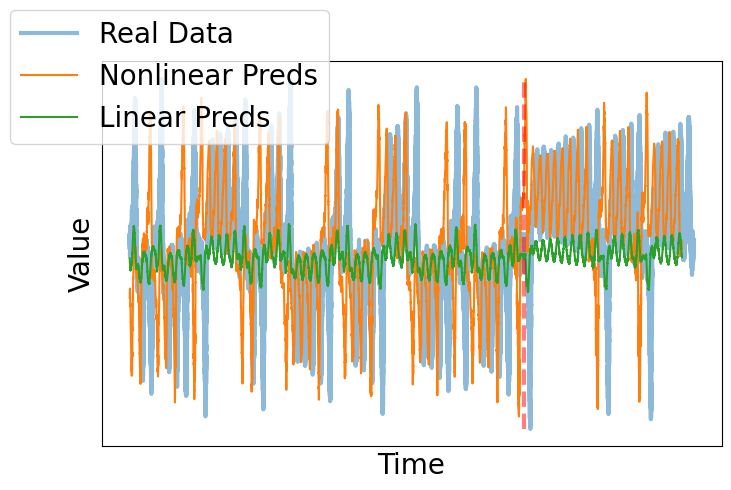

In [248]:
#Test the models on all the  traingin. validation and test, then plot the reaò data and the predictions
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

nonlinear_final_step_predictions = []
linear_final_step_predictions = []

nonlinear_model.eval()
linear_model.eval()

with torch.no_grad():

    for inputs, _ in train_loader:
        nonlinear_outputs = nonlinear_model(inputs.view(inputs.size(0), -1))
        linear_outputs = linear_model(inputs.view(inputs.size(0), -1))
        # Collect the last scalar from each output sequence
        nonlinear_final_step_predictions.extend(nonlinear_outputs[:, -1].numpy())
        linear_final_step_predictions.extend(linear_outputs[:, -1].numpy())

    for inputs, _ in val_loader:
        nonlinear_outputs = nonlinear_model(inputs.view(inputs.size(0), -1))
        linear_outputs = linear_model(inputs.view(inputs.size(0), -1))
        # Collect the last scalar from each output sequence
        nonlinear_final_step_predictions.extend(nonlinear_outputs[:, -1].numpy())
        linear_final_step_predictions.extend(linear_outputs[:, -1].numpy())

    for inputs, _ in test_loader:
        nonlinear_outputs = nonlinear_model(inputs.view(inputs.size(0), -1))
        linear_outputs = linear_model(inputs.view(inputs.size(0), -1))
        # Collect the last scalar from each output sequence
        nonlinear_final_step_predictions.extend(nonlinear_outputs[:, -1].numpy())
        linear_final_step_predictions.extend(linear_outputs[:, -1].numpy())

# Adjust prediction_time_steps to align with the test data
prediction_time_steps = np.arange(output_sequence_length + input_sequence_length , len(y))

plt.figure(figsize=(8, 5))

# Plot all y-values in the test time series
plt.plot(y, label='Real Data', linewidth = 3, alpha = 0.5)

# Overlay the predictions
plt.plot(nonlinear_final_step_predictions, label='Nonlinear Preds')
plt.plot(linear_final_step_predictions, label='Linear Preds')
plt.vlines(end_train_index, ymin=min(y), ymax=max(y), colors='red', alpha = 0.5, linestyles='dashed',linewidth = 3)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Value', fontsize=20)
plt.legend(fontsize=20, bbox_to_anchor=(-0.17, 1.17), loc='upper left')
plt.xticks([])
plt.yticks([])
#plt.savefig('figs/Nonlinear_vs_Linear.pdf')
plt.show()







In [249]:
nonlinear_final_step_predictions

[-7.080164,
 -7.036916,
 -7.053191,
 -7.028408,
 -6.9869337,
 -6.883813,
 -6.8884783,
 -6.727828,
 -6.7307444,
 -6.6912613,
 -6.574067,
 -6.5666847,
 -6.4801865,
 -6.46371,
 -6.292201,
 -6.288289,
 -6.2484426,
 -6.165391,
 -6.078911,
 -5.9108057,
 -5.779855,
 -5.7869997,
 -5.869441,
 -5.822571,
 -5.8183546,
 -5.791833,
 -5.6874647,
 -5.8742676,
 -5.9614773,
 -6.0750766,
 -6.190275,
 -6.340467,
 -6.474476,
 -6.629704,
 -6.7781067,
 -6.908634,
 -7.060935,
 -6.993255,
 -7.1345844,
 -7.2958164,
 -7.2852287,
 -7.5519686,
 -7.4874544,
 -7.6160088,
 -7.7090955,
 -7.6893845,
 -7.816351,
 -7.8194103,
 -7.922602,
 -8.060129,
 -8.0175085,
 -8.166352,
 -8.036212,
 -8.137317,
 -8.232302,
 -8.253301,
 -8.3431635,
 -8.233573,
 -8.249957,
 -8.162986,
 -8.263389,
 -8.259157,
 -8.227439,
 -8.228139,
 -8.118937,
 -8.021845,
 -7.9720516,
 -7.8938127,
 -8.011522,
 -8.3422785,
 -8.794175,
 -9.322593,
 -9.8052435,
 -9.890422,
 -10.052749,
 -10.171164,
 -10.167942,
 -10.26422,
 -10.303788,
 -10.449912,
 -10.5

In [250]:
#Now we want to see how the model is able to predict the time series if we change the amplitude of the data. 
#We will use the same model and the same test data, but we will rescale the data before feeding it to the model and track how the loss changes.
from tqdm import tqdm
import plotly.graph_objects as go
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define ranges for scaling and shifting
scale_factors = np.linspace(0.01, 10.0, 10)  # Example range for scale factors
shift_factors = np.linspace(-100, 100, 10)  # Example range for shift factors

# Original test data (assuming X_test, y_test are your test sets)
original_X_test = X_test.copy()
original_y_test = y_test.copy()

# Store the results
scale_values = []
shift_values = []
nonlinear_losses = []
linear_losses = []

# Total number of iterations for the progress bar
total_iterations = len(scale_factors) * len(shift_factors)

# Initialize tqdm progress bar
pbar = tqdm(total=total_iterations, desc='Evaluating', unit='iter')

# Evaluate the model on rescaled data
for scale in scale_factors:
    for shift in shift_factors:
        # Rescale test data
        rescaled_X_test = original_X_test * scale + shift
        rescaled_y_test = original_y_test * scale + shift
        rescaled_test_dataset = CustomDataset(rescaled_X_test, rescaled_y_test)
        rescaled_test_loader = DataLoader(rescaled_test_dataset, batch_size=batch_size, shuffle=False)

        # Make predictions and calculate loss
        nonlinear_model.eval()
        linear_model.eval()
        nonlinear_test_predictions = []
        linear_test_predictions = []
        with torch.no_grad():
            for inputs, targets in rescaled_test_loader:
                # Reshape inputs and make predictions
                nonlinear_outputs = nonlinear_model(inputs.view(inputs.size(0), -1))
                linear_outputs = linear_model(inputs.view(inputs.size(0), -1))
                # Collect the last scalar from each output sequence
                nonlinear_test_predictions.extend(nonlinear_outputs.numpy())
                linear_test_predictions.extend(linear_outputs.numpy())

        # Convert predictions list to numpy array
        nonlinear_test_predictions = np.array(nonlinear_test_predictions)
        linear_test_predictions = np.array(linear_test_predictions)

        # Calculate Mean Squared Error
        nonlinear_loss = mean_squared_error(rescaled_y_test, nonlinear_test_predictions)
        linear_loss = mean_squared_error(rescaled_y_test, linear_test_predictions) 

        # Store results
        scale_values.append(scale)
        shift_values.append(shift)
        nonlinear_losses.append(nonlinear_loss)
        linear_losses.append(linear_loss)

        # Update progress bar
        pbar.update(1)

# Close the progress bar
pbar.close()





Evaluating: 100%|██████████| 100/100 [01:05<00:00,  1.53iter/s]


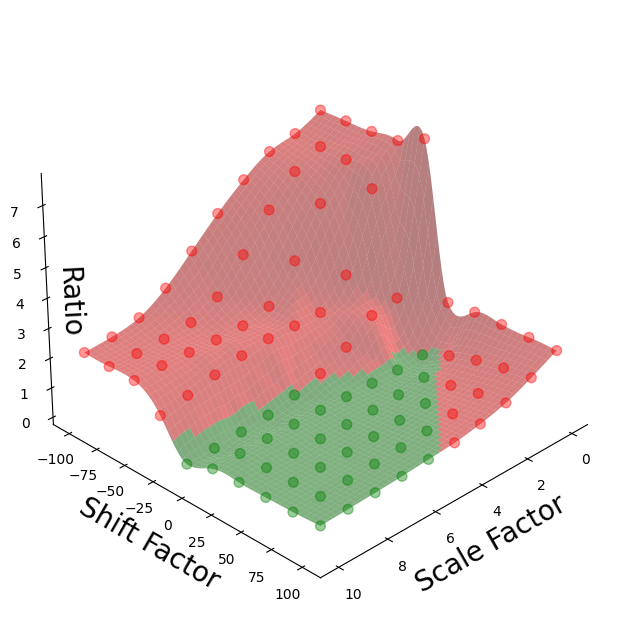

In [251]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.transforms import Bbox
import numpy as np
from scipy.interpolate import griddata

# 3D plot of nonlinear loss / linear loss against scaling and shifting factors
# If the ratio is less than 1, make the marker green, otherwise make it red
ratio = [nonlinear_losses[i]/linear_losses[i] for i in range(len(nonlinear_losses))]  
colors = ['green' if r < 1 else 'red' for r in ratio]  


# Data points in space for interpolation
points = np.array(list(zip(scale_values, shift_values)))

# Create grid coordinates for interpolation
xi, yi = np.linspace(min(scale_values), max(scale_values), 100), np.linspace(min(shift_values), max(shift_values), 100)
xi, yi = np.meshgrid(xi, yi)

# Interpolate z values on grid
zi = griddata(points, ratio, (xi, yi), method='cubic')

# Define colors for the surface based on zi values
surface_colors = np.where(zi < 1, 'green', 'red')  # 'green' for zi < 1, 'red' otherwise

# Create a new matplotlib figure and 3D axes
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, projection='3d')

ax.set_position(Bbox.from_bounds(-0, -0.02, 1, 1.2))

# Surface plot with variable colors
surface = ax.plot_surface(xi, yi, zi, facecolors=surface_colors, edgecolor='none', alpha=0.5)

# Scatter plot
scatter = ax.scatter(scale_values, shift_values, ratio, c=colors, s=50, alpha=0.4)



# Labeling axes
ax.set_xlabel('Scale Factor', fontsize=20, labelpad=5)
ax.set_ylabel('Shift Factor', fontsize=20, labelpad=5)
#move up the label
ax.set_zlabel('Ratio', fontsize=20, labelpad=-30, verticalalignment='top')


# Adjust the viewing angle
ax.view_init(elev=30, azim=45)  # elevation and azimuth

# Remove grid lines and background
ax.grid(False)  # Turn off the grid
ax.xaxis.pane.fill = False  # Remove the background pane
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('white')  # Set edges to white (invisible on a white background)
ax.yaxis.pane.set_edgecolor('white')
ax.zaxis.pane.set_edgecolor('white')



# Show plot
plt.savefig('figs/3d_plot.pdf')
plt.show()

